In [1]:
import torch

MODELS_FOLDER = 'models'
# torch.cuda.is_available = lambda: False
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


## Process Text

In [2]:
import re
from collections import Counter

def data_to_lower(data):
  return [text.lower() for text in data]

def data_remove_punctuation(data):
  return [re.sub(r'[^\w\s]', '', text) for text in data]

def data_remove_stopwords(data):
  stopwords_list = open(
    './src/stopwords-tl.txt',
    'r',
  ).read().split('\n')
  stopwords_dict = Counter(stopwords_list)
  return [
    ' '.join([
      word for word in sample.split()
      if word not in stopwords_dict
    ])
    for sample 
    in data
  ]

def process_text(inputs: list):
  inputs = data_to_lower(inputs)
  inputs = data_remove_punctuation(inputs)
  inputs = data_remove_stopwords(inputs)
  return inputs

## Bernoulli Naive Bayes

In [3]:
import joblib
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
try:
  tfidf = joblib.load(f'{MODELS_FOLDER}/model_bayes/best/tfidf.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

In [5]:
tfidf

TfidfVectorizer()

In [6]:
tfidf.vocabulary_

{'matthew': 22940,
 'chang': 6116,
 'username': 40537,
 'remind': 33445,
 'lang': 18911,
 'di': 8399,
 'ba': 2913,
 'galit': 11673,
 'dun': 9264,
 'taong': 38057,
 'marunong': 22697,
 'magbayad': 20598,
 'utang': 40906,
 'tapos': 38091,
 'kay': 17594,
 'marcos': 22467,
 'iboboto': 14295,
 'mo': 23750,
 'well': 41870,
 'magnanakaw': 20864,
 'never': 26768,
 'again': 1092,
 'yay': 42578,
 'the': 38515,
 'interview': 15257,
 'served': 35426,
 'its': 15858,
 'purpose': 32692,
 'welljessica': 41882,
 'soho': 36453,
 'interviews': 15269,
 'angat': 1887,
 'buhay': 5203,
 'lahatkakampink': 18758,
 'say': 34994,
 'dasurv': 7792,
 'taynew': 38232,
 'said': 34561,
 'let': 19502,
 'leni': 19304,
 'lead': 19157,
 'gloc': 12078,
 'is': 15579,
 'not': 27442,
 'endorsing': 10022,
 'jejomar': 16088,
 'binay': 4124,
 'as': 2457,
 'his': 13771,
 'presidential': 32027,
 'bet': 3893,
 '2016': 191,
 'elections': 9803,
 'polls': 31609,
 'proud': 32395,
 'to': 39050,
 'kakampink': 16808,
 'po': 31382,
 'nanay

In [7]:
try:
  BayesModel = joblib.load(f'{MODELS_FOLDER}/model_bayes/best/bayes.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

In [8]:
BayesModel

BernoulliNB()

In [9]:
def predict_bayes(inputs: list):
  inputs = process_text(inputs)
  inputs_transformed = tfidf.transform(inputs)
  predictions = BayesModel.predict(inputs_transformed)
  return predictions

def predict_proba_bayes(inputs: list):
  inputs = process_text(inputs)
  inputs_transformed = tfidf.transform(inputs)
  predictions = BayesModel.predict_proba(inputs_transformed)
  return predictions

## LSTM

In [12]:
import calamancy

Calamancy = calamancy.load("tl_calamancy_md-0.1.0")

Calamancy

/home/nate/miniconda3/lib/python3.9/site-packages/spacy/util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn_msg)
/home/nate/miniconda3/lib/python3.9/site-packages/spacy/util.py:918: UserWarning: [W094] Model 'tl_calamancy_lg' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn

In [13]:
import pandas as pd
import numpy as np
from torch import Tensor

def get_calamancy_tokens(data):
  # Allows it to work with both dataframes and
  # simple lists of strings
  if isinstance(data, pd.Series):
    data = data.values

  samples = []

  for sample in Calamancy.pipe(data):
    tokens = [
      token
      for token
      in sample
    ]

    samples.append(tokens)

  return samples

def get_token_vectors(tokens):
  vectors = []

  for sample in tokens:
    # vector = Tensor(np.array([token.vector for token in sample]))
    token_vectors = []
    # Check in case empty due to processing
    if not sample:
      token_vectors.append(np.zeros((200)))
    else:
      for token in sample:
        if token.has_vector:
          token_vectors.append(token.vector)
    token_vectors = Tensor(np.array(token_vectors))

    vectors.append(token_vectors)

  return vectors

/tmp/ipykernel_54274/3902775969.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [14]:
import torch
from torch import nn

INPUT_SIZE = 200
LSTM_OUTPUT_SIZE = 50
LINEAR_OUTPUT_SIZE = 2

In [15]:
class LstmModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(
      INPUT_SIZE,
      LSTM_OUTPUT_SIZE,
      batch_first=True,
    )
    self.linear = nn.Linear(LSTM_OUTPUT_SIZE, LINEAR_OUTPUT_SIZE)

  def forward(self, input):
    lstm_output, _ = self.lstm(input)

    linear_output = self.linear(lstm_output[:, -1])

    return linear_output

Lstm = LstmModel()
Lstm.load_state_dict(
  torch.load(
    f"{MODELS_FOLDER}/model_lstm/best/lstm_checkpoint.pth",
    map_location=DEVICE,
  )['model']
)

Lstm.to(DEVICE)

LstmModel(
  (lstm): LSTM(200, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [16]:
Lstm.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 0.0044,  0.0110, -0.1856,  ..., -0.0106,  0.1421, -0.0032],
                      [-0.1662, -0.1862,  0.1816,  ...,  0.0653,  0.1271,  0.2315],
                      [ 0.2418, -0.1764,  0.0944,  ...,  0.1940,  0.3669,  0.0230],
                      ...,
                      [-0.1574,  0.0034,  0.0145,  ...,  0.0421, -0.0214, -0.0128],
                      [-0.0008, -0.2258, -0.0258,  ...,  0.1488, -0.0903,  0.1439],
                      [-0.0588,  0.2799,  0.0056,  ..., -0.1538,  0.0167, -0.1506]],
                     device='cuda:0')),
             ('lstm.weight_hh_l0',
              tensor([[-0.0161, -0.1398,  0.0613,  ..., -0.1284,  0.1561, -0.0776],
                      [ 0.0369, -0.0138, -0.2119,  ...,  0.1446,  0.0386, -0.0629],
                      [-0.1724, -0.2996, -0.1468,  ..., -0.0431,  0.0594, -0.1251],
                      ...,
                      [-0.0423,  0.0696,  0.1803,  ...,  0.0235,  0.2423, -0.13

In [17]:
softmax_function = nn.Softmax(dim=1)

In [18]:
def process_lstm(inputs: list):
  inputs = process_text(inputs)
  tokens = get_calamancy_tokens(inputs)
  vectors = get_token_vectors(tokens)
  return vectors

def predict_proba_lstm(inputs: list):
  vectors = process_lstm(inputs)
  preds = []
  for sample in vectors:
    sample = torch.stack([sample]).to(DEVICE)
    sample_pred = Lstm(sample)
    preds.append(sample_pred)
  preds = torch.cat(preds)
  probabilities = softmax_function(preds)

  return probabilities.cpu()

def predict_lstm(inputs: list):
  probabilities = predict_proba_lstm(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities


## mBERT

In [21]:
BERT_MAX_LENGTH = 250
BERT_MODEL_NAME = "bert-base-multilingual-uncased"

In [22]:
from transformers import (
  BertForSequenceClassification,
  BertTokenizer
)

/home/nate/miniconda3/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/nate/miniconda3/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [23]:
bert_tokenizer = BertTokenizer.from_pretrained(
  BERT_MODEL_NAME
)

In [ ]:
Bert = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME)
Bert.load_state_dict(
  torch.load(
    f"{MODELS_FOLDER}/model_bert/best/bert_checkpoint.pth",
    map_location=torch.device('cpu'),
  )['model']
)

Bert.to(DEVICE)

In [ ]:
Bert.state_dict()

In [26]:
def process_bert(inputs):
    input_ids = []
    attention_masks = []

    for text in inputs:
        # Tokenize the text
        tokens = bert_tokenizer.tokenize(text)

        # Truncate the tokens if necessary
        if len(tokens) > BERT_MAX_LENGTH - 2:
            tokens = tokens[:BERT_MAX_LENGTH - 2]

        # Add special tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        # Convert tokens to token IDs
        token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)

        # Pad the token IDs to BERT_MAX_LENGTH
        padding = [0] * (BERT_MAX_LENGTH - len(token_ids))
        token_ids += padding

        # Create attention mask
        attention_mask = [1] * len(tokens) + [0] * len(padding)

        input_ids.append(token_ids)
        attention_masks.append(attention_mask)

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids).to(DEVICE)
    attention_masks = torch.tensor(attention_masks).to(DEVICE)

    return input_ids, attention_masks

# Custom data loader
def data_loader(input_ids, attention_masks, batch_size):
    for i in range(0, len(input_ids), batch_size):
        yield input_ids[i:i+batch_size], attention_masks[i:i+batch_size]

def predict_proba_bert(inputs: list):
  with torch.inference_mode():
    input_ids, attention_masks = process_bert(inputs)

    all_predictions = []
    for batch_input_ids, batch_attention_masks in data_loader(input_ids, attention_masks, 5):
      batch_input_ids = batch_input_ids.to(DEVICE)
      batch_attention_masks = batch_attention_masks.to(DEVICE)

      predictions = Bert(
        batch_input_ids,
        attention_mask=batch_attention_masks,
      ).logits

      probabilities = softmax_function(predictions)

      all_predictions.append(probabilities)

    return torch.cat(all_predictions).cpu()

def predict_bert(inputs: list):
  probabilities = predict_proba_bert(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities

In [27]:
bert_results = predict_proba_bert([
  'mahal kita, gago',
  'mahal na mahal kita',
  'tangina pare mo',
  'tangina mo pare',
  'pare mo tangina',
  'i love you uwu',
])

bert_results

tensor([[0.6811, 0.3189],
        [0.9960, 0.0040],
        [0.0071, 0.9929],
        [0.0060, 0.9940],
        [0.0085, 0.9915],
        [0.9947, 0.0053]])

## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

LogReg = joblib.load(f'{MODELS_FOLDER}/model_lr/best/lr.pkl')

LogReg

/home/nate/miniconda3/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


LogisticRegression()

## Ensemble Methods

In [30]:
def get_learner_predictions(inputs: list):
  bayes_pred = predict_bayes(inputs)
  lstm_pred = predict_lstm(inputs)
  bert_pred = predict_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred,
    bert_pred,
  ])

def get_learner_predictions_proba(inputs: list):
  bayes_pred = predict_proba_bayes(inputs)
  lstm_pred = predict_proba_lstm(inputs)
  bert_pred = predict_proba_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred.detach().numpy(),
    bert_pred.detach().numpy(),
  ])

In [33]:
def hard_voting(inputs: list):
  preds = get_learner_predictions(inputs)
  results = np.apply_along_axis(
      lambda x: np.bincount(x).argmax(),
      axis=0,
      arr=preds
  )
  return results

In [34]:
def soft_voting(inputs: list):
  preds = get_learner_predictions_proba(inputs)
  results = np.average(
      preds, axis=0,
  )
  return results

In [35]:
def stacking(inputs: list):
  preds = get_learner_predictions_proba(inputs)

  # Get only the predictions for hate speech
  # Since logistic regression is implemented
  # to assume that you give it the data for 1
  preds = preds[:, :, 1:]

  # Transpose so all learners' preds are on the same row
  transposed_preds = preds.T[0]

  return LogReg.predict_proba(transposed_preds)

## Results

In [36]:
import numpy as np
import pandas as pd
import torch
import math

random_number_generator = np.random.default_rng(seed=0)
def shuffle_data_frame(data_frame):
    text = list(data_frame['text'])
    label = list(data_frame['label'])

    assert(len(text) == len(label))

    indices = list(range(len(label)))

    # Make a random number generator that will shuffle list of indices
    # It is seeded to be reproducible
    random_number_generator.shuffle(indices)

    shuffled_text = []
    shuffled_labels = []

    # Iterate through the list of indices and add the original data
    # from those shuffled indices
    for index in indices:
        shuffled_text.append(text[index])
        shuffled_labels.append(label[index])

    return pd.DataFrame({
        'text': shuffled_text,
        'label': shuffled_labels,
    })


def get_train_test_split(data_frame: pd.DataFrame, test_size: float):
    """
    Makes a stratified train test split.
    This aims to preserve the distribution between classes.
    """
    if not (1 > test_size > 0):
        print('ERROR: test_size must be between 0 and 1')
        return

    data_frame = shuffle_data_frame(data_frame)

    data_frame_length = len(data_frame)
    train_size = 1 - test_size

    nonhate_rows = data_frame[data_frame['label'] == 0]
    nonhate_row_length = len(nonhate_rows)

    nonhate_row_train_size = math.ceil(nonhate_row_length * train_size)

    nonhate_row_train = nonhate_rows[0:nonhate_row_train_size]
    nonhate_row_test = nonhate_rows[nonhate_row_train_size:nonhate_row_length]

    assert(len(nonhate_row_train) + len(nonhate_row_test) == nonhate_row_length)

    hate_rows = data_frame[data_frame['label'] == 1]
    hate_row_length = len(hate_rows)

    hate_row_train_size = math.ceil(hate_row_length * train_size)

    hate_row_train = hate_rows[0:hate_row_train_size]
    hate_row_test = hate_rows[hate_row_train_size:hate_row_length]

    assert(len(hate_row_train) + len(hate_row_test) == hate_row_length)

    combined_train = pd.concat([nonhate_row_train, hate_row_train])
    combined_test = pd.concat([nonhate_row_test, hate_row_test])

    assert(len(combined_train) + len(combined_test) == data_frame_length)

    shuffled_train = shuffle_data_frame(combined_train)
    shuffled_test = shuffle_data_frame(combined_test)

    assert(len(shuffled_train) + len(shuffled_test) == data_frame_length)

    return (
        shuffled_train['text'],
        shuffled_test['text'],
        shuffled_train['label'],
        shuffled_test['label'],
    )

def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

In [37]:
dataset = read_csv_file('datasets/datasetall.csv')

dataset

CSV file read successfully!


,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0
2,wait so ur telling me Let Leni Lead mo pero NY...,1
3,[USERNAME]wish this is just a nightmare that ...,0
4,doc willie ong and isko sabunutan po,0
...,...,...
28456,"Bisaya, Probinsyano/a, mostly Bisaya = katulong",1
28457,Amnesia. In my whole life wala pa ako nakasala...,1
28458,Kontrabida na ilang beses na tinalo at obvious...,1
28459,Yung antagonist laging kailangang sobrang sama...,1


In [38]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = get_train_test_split(dataset, TEST_SIZE)

In [39]:
X_test

0       Hindi susuportahan ng theatre and literary est...
1       BABAE LABAN SA FAKE AT FRAUDBFFSUMBONGDAYA DES...
2       Im proud to be a Filipino and a kakampink like...
3       Grabe noThe hypocrisy of the church to preach ...
4                         BBMSARAUniteam Ph Arena BBMSARA
                              ...                        
5687    [USERNAME] Rizalito David is a good man you ca...
5688    A very famous religious cult in the Philippine...
5689    Tama sir VP Leni Di dapat iboto SI BBM Kase No...
5690    RT [USERNAME]: Mar Roxas forever arrogantI can...
5691                             Let Leni Lead Kakampinks
Name: text, Length: 5692, dtype: object

In [40]:
y_test

0       0
1       1
2       0
3       1
4       0
       ..
5687    0
5688    1
5689    0
5690    1
5691    0
Name: label, Length: 5692, dtype: int64

In [41]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Hard Voting

In [42]:
hard_results = hard_voting(X_test)

hard_results

array([0, 1, 0, ..., 0, 1, 0])

### Metrics

In [43]:
print(f"Accuracy: {accuracy_score(y_test, hard_results)}")
print(f"Recall: {recall_score(y_test, hard_results)}")
print(f"Precision: {precision_score(y_test, hard_results)}")
print(f"F1: {f1_score(y_test, hard_results)}")

Accuracy: 0.8562895291637386
Recall: 0.8874172185430463
Precision: 0.8372245971719829
F1: 0.8615905245346869


### Confusion Matrix

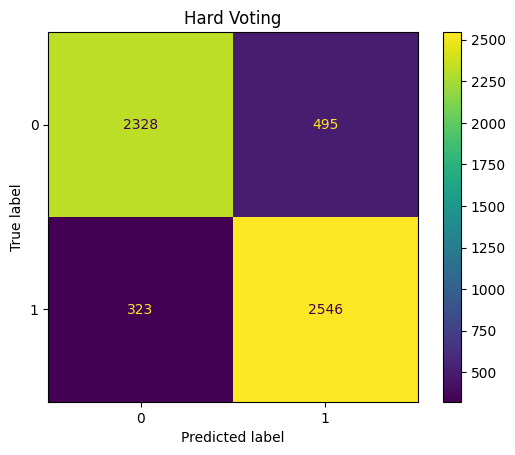

In [44]:
hard_conf_matrix = confusion_matrix(y_test, hard_results)
hard_conf_matrix_display = ConfusionMatrixDisplay(hard_conf_matrix)
hard_conf_matrix_display.plot()
plt.title("Hard Voting")
plt.show()

## Soft Voting

In [45]:
soft_results = soft_voting(X_test)

soft_results

array([[0.61094497, 0.38905505],
       [0.45931454, 0.54068547],
       [0.99290286, 0.00709712],
       ...,
       [0.77605698, 0.22394304],
       [0.06368316, 0.93631683],
       [0.99657054, 0.00342945]])

### Metrics

In [46]:
soft_results_discrete = np.argmax(soft_results, axis=1)

print(f"Accuracy: {accuracy_score(y_test, soft_results_discrete)}")
print(f"Recall: {recall_score(y_test, soft_results_discrete)}")
print(f"Precision: {precision_score(y_test, soft_results_discrete)}")
print(f"F1: {f1_score(y_test, soft_results_discrete)}")

Accuracy: 0.8557624736472241
Recall: 0.8915998605785989
Precision: 0.833767926988266
F1: 0.8617146707091123


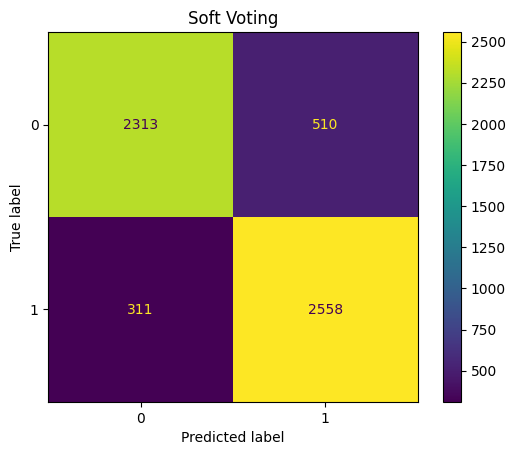

In [47]:
soft_conf_matrix = confusion_matrix(y_test, soft_results_discrete)
soft_conf_matrix_display = ConfusionMatrixDisplay(soft_conf_matrix)
soft_conf_matrix_display.plot()
plt.title("Soft Voting")
plt.show()

## Stacking

In [48]:
stacking_results = stacking(X_test)

stacking_results

array([[0.40169072, 0.59830928],
       [0.27963418, 0.72036582],
       [0.99814768, 0.00185232],
       ...,
       [0.99659895, 0.00340105],
       [0.01759166, 0.98240834],
       [0.99821001, 0.00178999]])

### Metrics

In [49]:
stacking_results_discrete = np.argmax(stacking_results, axis=1)

print(f"Accuracy: {accuracy_score(y_test, stacking_results_discrete)}")
print(f"Recall: {recall_score(y_test, stacking_results_discrete)}")
print(f"Precision: {precision_score(y_test, stacking_results_discrete)}")
print(f"F1: {f1_score(y_test, stacking_results_discrete)}")

Accuracy: 0.8610330288123682
Recall: 0.8773091669571279
Precision: 0.8514884979702301
F1: 0.864206008583691


### Confusion Matrix

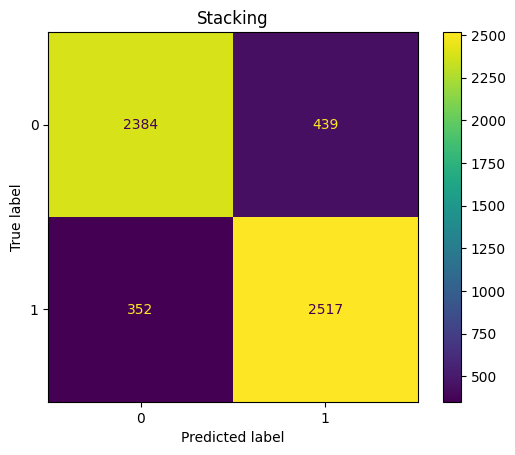

In [50]:
stacking_conf_matrix = confusion_matrix(y_test, stacking_results_discrete)
stacking_conf_matrix_display = ConfusionMatrixDisplay(stacking_conf_matrix)
stacking_conf_matrix_display.plot()
plt.title("Stacking")
plt.show()